In [1]:
import torch
import torchvision

# Perform OCR on image

import matplotlib.pyplot as plt
import os
import json
import pandas as pd
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
import numpy as np

In [2]:
from pathlib import Path
from uuid import uuid4
# from label_studio_sdk import Client
# from label_studio_sdk import Project
# from label_studio_sdk.data_manager import Column, Filters, Operator, Type
from datetime import datetime
from doctr.io import DocumentFile
from doctr.models import ocr_predictor
from PIL import Image, ImageDraw, ImageFont
import numpy as np
import re
import sys
import time
import os 
from os.path import join
from xml.dom import minidom
import json
# from pdf2image import convert_from_path
from PIL import Image
import torch
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler, Dataset
from torch.utils.data.distributed import DistributedSampler
from tqdm import tqdm, trange
from torch import nn
from torch.nn import CrossEntropyLoss, MSELoss
from transformers import BertConfig, BertModel, BertPreTrainedModel, get_linear_schedule_with_warmup, AdamW, BertTokenizerFast
from torch.nn import LayerNorm as BertLayerNorm
import torch
import torchvision
import json
import os
from PIL import Image, ImageDraw, ImageFont
import cv2
import matplotlib.pyplot as plt
import os
import json
import pandas as pd
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
import numpy as np

/home/abhishek/doctr_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
def get_all_NH_data_u():
  directory = 'experiment_other/'

  # iterate over files
  words=[]
  label = []
  bbox = []
  files=[]
  # for filename in os.listdir(directory):
  f = os.path.join(directory, "NH BC 00150.json")
  # checking if it is a file
  if os.path.isfile(f):
    dataraw = open(f) 
    jdata = json.load(dataraw)
    for num in range(len(jdata)):
        word = []
        box = []   
        page = jdata[num] 
        files.append(page['data']['ocr'])
        for i in page['predictions'][0]['result']:             
          val = i['value']
          if 'text' in val.keys():
            word.append(val['text'][0])
            x1=val['x']
            y1=val['y']
            x2=val['x']+val['width']
            y2=val['y']+val['height']
            box.append([x1,y1,x2,y2])
          # box = normalize_bbox(box, width=width, height=height) 
        words.append(word)
        bbox.append(box)               
  all_data = list(zip(words,bbox,files))
  u_ocr_data = pd.DataFrame(all_data, columns=['word','bbox','files'])

  return u_ocr_data

In [4]:
ocr_data = get_all_NH_data_u()
print(ocr_data)

                                                word  \
0  [DEPARIMENT, OF, LABORATORY, MEDICINE, MRN, Na...   
1  [DEPARTMENT, OF, LABORATORY, MEDICINE, MRN, Na...   
2  [DEPARTMENT, OF, LABORATORY, MEDICINE, MRN, Na...   

                                                bbox  \
0  [[27.1484375, 12.20703125, 40.91796875, 13.281...   
1  [[27.1484375, 11.81640625, 41.015625, 13.18359...   
2  [[27.1484375, 11.9140625, 41.11328125, 13.2812...   

                                               files  
0  http://localhost:8081/pdf_images/NH BC 00150/N...  
1  http://localhost:8081/pdf_images/NH BC 00150/N...  
2  http://localhost:8081/pdf_images/NH BC 00150/N...  


In [5]:
x=ocr_data['word'].to_list()
z=ocr_data['bbox'].to_list()
q=ocr_data['files'].to_list()

In [6]:
temp=[]
y=[]
for i in range(len(x)):
    for j in range(len(x[i])):
        temp.append("Text")
    y.append(temp)

In [7]:
all_data = list(zip(x,y,z,q)) 
# Pandas DF of cord data containing WORD, LABEL and BBOX
ocr_data = pd.DataFrame(all_data, columns=['word','label','bbox','file']) 
# ocr_data['bbox']
token_train=ocr_data['word'].to_numpy()
label_train=ocr_data['label'].to_numpy()
boxe_train=ocr_data['bbox'].to_numpy()
file_name=ocr_data['file'].to_numpy() 
# print(boxe_train)
import pickle
with open('./NH_Paths/experiment.pkl', 'wb') as t:
    pickle.dump(np.array([token_train, label_train, boxe_train, file_name]), t)

In [8]:
class CordDataset(Dataset):
    def __init__(self, examples, tokenizer, labels, pad_token_label_id):
        features = convert_examples_to_featuresz(
            examples,
            labels,
            max_seq_length,
            tokenizer,
            cls_token_at_end=False,
            cls_token=tokenizer.cls_token,
            cls_token_segment_id=0,
            sep_token=tokenizer.sep_token,
            sep_token_extra=False,
            pad_on_left=False,
            pad_token=tokenizer.convert_tokens_to_ids([tokenizer.pad_token])[0],
            pad_token_segment_id=0,
            pad_token_label_id=pad_token_label_id,
        )

        self.features = features
        self.all_input_ids = torch.tensor(
            [f.input_ids for f in features], dtype=torch.long
        )
        self.all_input_mask = torch.tensor(
            [f.input_mask for f in features], dtype=torch.long
        )
        self.all_segment_ids = torch.tensor(
            [f.segment_ids for f in features], dtype=torch.long
        )
        self.all_label_ids = torch.tensor(
            [f.label_ids for f in features], dtype=torch.long
        )
        self.all_bboxes = torch.tensor([f.boxes for f in features], dtype=torch.long)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, index):
        return (
            self.all_input_ids[index],
            self.all_input_mask[index],
            self.all_segment_ids[index],
            self.all_label_ids[index],
            self.all_bboxes[index],
        )

class InputFeatures(object):
    def __init__(
        self,
        input_ids,
        input_mask,
        segment_ids,
        label_ids,
        boxes
    ):
        assert (
            0 <= all(boxes) <= 1000
        ), "Error with input bbox ({}): the coordinate value is not between 0 and 1000".format(
            boxes
        )
        self.input_ids = input_ids
        self.input_mask = input_mask
        self.segment_ids = segment_ids
        self.label_ids = label_ids
        self.boxes = boxes

def convert_examples_to_featuresz(
    examples,
    label_list,
    max_seq_length,
    tokenizer,
    cls_token_at_end=False,
    cls_token="[CLS]",
    cls_token_segment_id=1,
    sep_token="[SEP]",
    sep_token_extra=False,
    pad_on_left=False,
    pad_token=0,
    cls_token_box=[0, 0, 0, 0],
    sep_token_box=[1000, 1000, 1000, 1000],
    pad_token_box=[0, 0, 0, 0],
    pad_token_segment_id=0,
    pad_token_label_id=-1,
    sequence_a_segment_id=0,
    mask_padding_with_zero=True,
):
    label_map = {label: i for i, label in enumerate(label_list)}

    features = []
    for i in range(len(examples[0])):
        width, height = 1000, 1000
        words = examples[0]
        labels = examples[1]
        boxes = examples[2]

        tokens = []
        token_boxes = []
        label_ids = []
        for word, label, box in zip(
            words[i], labels[i], boxes[i]
        ):
            if len(word) < 1:
              continue
            word_tokens = tokenizer.tokenize(word)
            tokens.extend(word_tokens)
            token_boxes.extend([box] * len(word_tokens))
            label_ids.extend(
                [label_map[label]] + [pad_token_label_id] * (len(word_tokens) - 1))
        special_tokens_count = 3 if sep_token_extra else 2
        if len(tokens) > max_seq_length - special_tokens_count:
            tokens = tokens[: (max_seq_length - special_tokens_count)]
            token_boxes = token_boxes[: (max_seq_length - special_tokens_count)]
            label_ids = label_ids[: (max_seq_length - special_tokens_count)]

        tokens += [sep_token]
        token_boxes += [sep_token_box]
        label_ids += [pad_token_label_id]
        if sep_token_extra:
            tokens += [sep_token]
            token_boxes += [sep_token_box]
            label_ids += [pad_token_label_id]
        segment_ids = [sequence_a_segment_id] * len(tokens)

        if cls_token_at_end:
            tokens += [cls_token]
            token_boxes += [cls_token_box]
            label_ids += [pad_token_label_id]
            segment_ids += [cls_token_segment_id]
        else:
            tokens = [cls_token] + tokens
            token_boxes = [cls_token_box] + token_boxes
            label_ids = [pad_token_label_id] + label_ids
            segment_ids = [cls_token_segment_id] + segment_ids

        input_ids = tokenizer.convert_tokens_to_ids(tokens)
        input_mask = [1 if mask_padding_with_zero else 0] * len(input_ids)
        padding_length = max_seq_length - len(input_ids)
        if pad_on_left:
            input_ids = ([pad_token] * padding_length) + input_ids
            input_mask = (
                [0 if mask_padding_with_zero else 1] * padding_length
            ) + input_mask
            segment_ids = ([pad_token_segment_id] * padding_length) + segment_ids
            label_ids = ([pad_token_label_id] * padding_length) + label_ids
            token_boxes = ([pad_token_box] * padding_length) + token_boxes
        else:
            input_ids += [pad_token] * padding_length
            input_mask += [0 if mask_padding_with_zero else 1] * padding_length
            segment_ids += [pad_token_segment_id] * padding_length
            label_ids += [pad_token_label_id] * padding_length
            token_boxes += [pad_token_box] * padding_length

        assert len(input_ids) == max_seq_length
        assert len(input_mask) == max_seq_length
        assert len(segment_ids) == max_seq_length
        assert len(label_ids) == max_seq_length
        assert len(token_boxes) == max_seq_length

        features.append(
            InputFeatures(
                input_ids=input_ids,
                input_mask=input_mask,
                segment_ids=segment_ids,
                label_ids=label_ids,
                boxes=token_boxes,
            )
        )
    return features

In [12]:
import pickle
path = './NH_Paths/'
demo = pickle.load(open(path + 'experiment.pkl', 'rb'))      
len(demo)
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

from collections import Counter
# all_labels = [item for sublist in demo[1] for item in sublist]
# Counter(all_labels)
# labels = list(set(all_labels))
# labels=['field','Text' ,'value']
labels=['value', 'Text' , 'field']
from torch.nn import CrossEntropyLoss
num_labels = len(labels)
label_map = {i: label for i, label in enumerate(labels)}
pad_token_label_id = CrossEntropyLoss().ignore_index

from transformers import LayoutLMTokenizer
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
max_seq_length = 512
tokenizer = LayoutLMTokenizer.from_pretrained("./NH_Paths/tokenizer_weights_mod___1%/", local_files_only=True)

demo_ = CordDataset(demo, tokenizer, labels, pad_token_label_id)
demo_sampler = SequentialSampler(demo_)
demo_dataloader = DataLoader(demo_, 
                             sampler=demo_sampler,
                            batch_size=2)   

from transformers import LayoutLMForTokenClassification
import torch

device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
model = LayoutLMForTokenClassification.from_pretrained("./NH_Paths/model_weights_mod___1%/pytorch_model.bin", config='./NH_Paths/model_weights_mod___1%/config.json', local_files_only=True)
# model.load_state_dict(torch.load("./model_weights.pth"))
model.to(device)

import numpy as np
preds = None
out_label_ids = None

model.eval()
for batch in tqdm(demo_dataloader, desc="Evaluating"):
    with torch.no_grad():
        input_ids = batch[0].to(device)
        bbox = batch[4].to(device)
        attention_mask = batch[1].to(device)
        token_type_ids = batch[2].to(device)
        labels = batch[3].to(device)
        # labels = batch[3].to(device)
        # forward pass
        outputs = model(input_ids=input_ids, bbox=bbox, attention_mask=attention_mask, token_type_ids=token_type_ids)
        # get the loss and logits
        # tmp_eval_loss = outputs.loss
        logits = outputs.logits
        if preds is None:
            preds = logits.detach().cpu().numpy()
            out_label_ids = labels.detach().cpu().numpy()
        else:
            preds = np.append(preds, logits.detach().cpu().numpy(), axis=0)
            out_label_ids = np.append(
                out_label_ids, labels.detach().cpu().numpy(), axis=0
            )

# compute average evaluation loss
preds = np.argmax(preds, axis=2)
print(len(preds))
out_label_list = [[] for _ in range(out_label_ids.shape[0])]
preds_list = [[] for _ in range(out_label_ids.shape[0])]

for i in range(out_label_ids.shape[0]):
    for j in range(out_label_ids.shape[1]):
        if out_label_ids[i, j] != pad_token_label_id:
            out_label_list[i].append(label_map[out_label_ids[i][j]])
            preds_list[i].append(label_map[preds[i][j]])
    print(len(preds_list[i]))
# from seqeval.metrics import accuracy_score as acc
# fm_test_acc = acc(out_label_list, preds_list)
# # print()
# print(fm_test_acc)

Evaluating: 100%|██████████| 2/2 [00:00<00:00, 71.96it/s]

3
209
197
86


In [13]:
for i in range(len(demo[2])):
    for j in range(len(demo[2][i])):
        x1 = demo[2][i][j][0]/100
        y1 = demo[2][i][j][1]/100
        x2 = ((demo[2][i][j][2]-demo[2][i][j][0])/100) + (demo[2][i][j][0]/100)
        y2 = ((demo[2][i][j][3]-demo[2][i][j][1])/100) + (demo[2][i][j][1]/100)
        width_w = x2-x1
        height_w = y2-y1
        width = 1654
        height = 2340
        demo[2][i][j] = [x1* width, y1*height, (x1*width) + (width_w*width), (y1*height) + (height_w*height)]

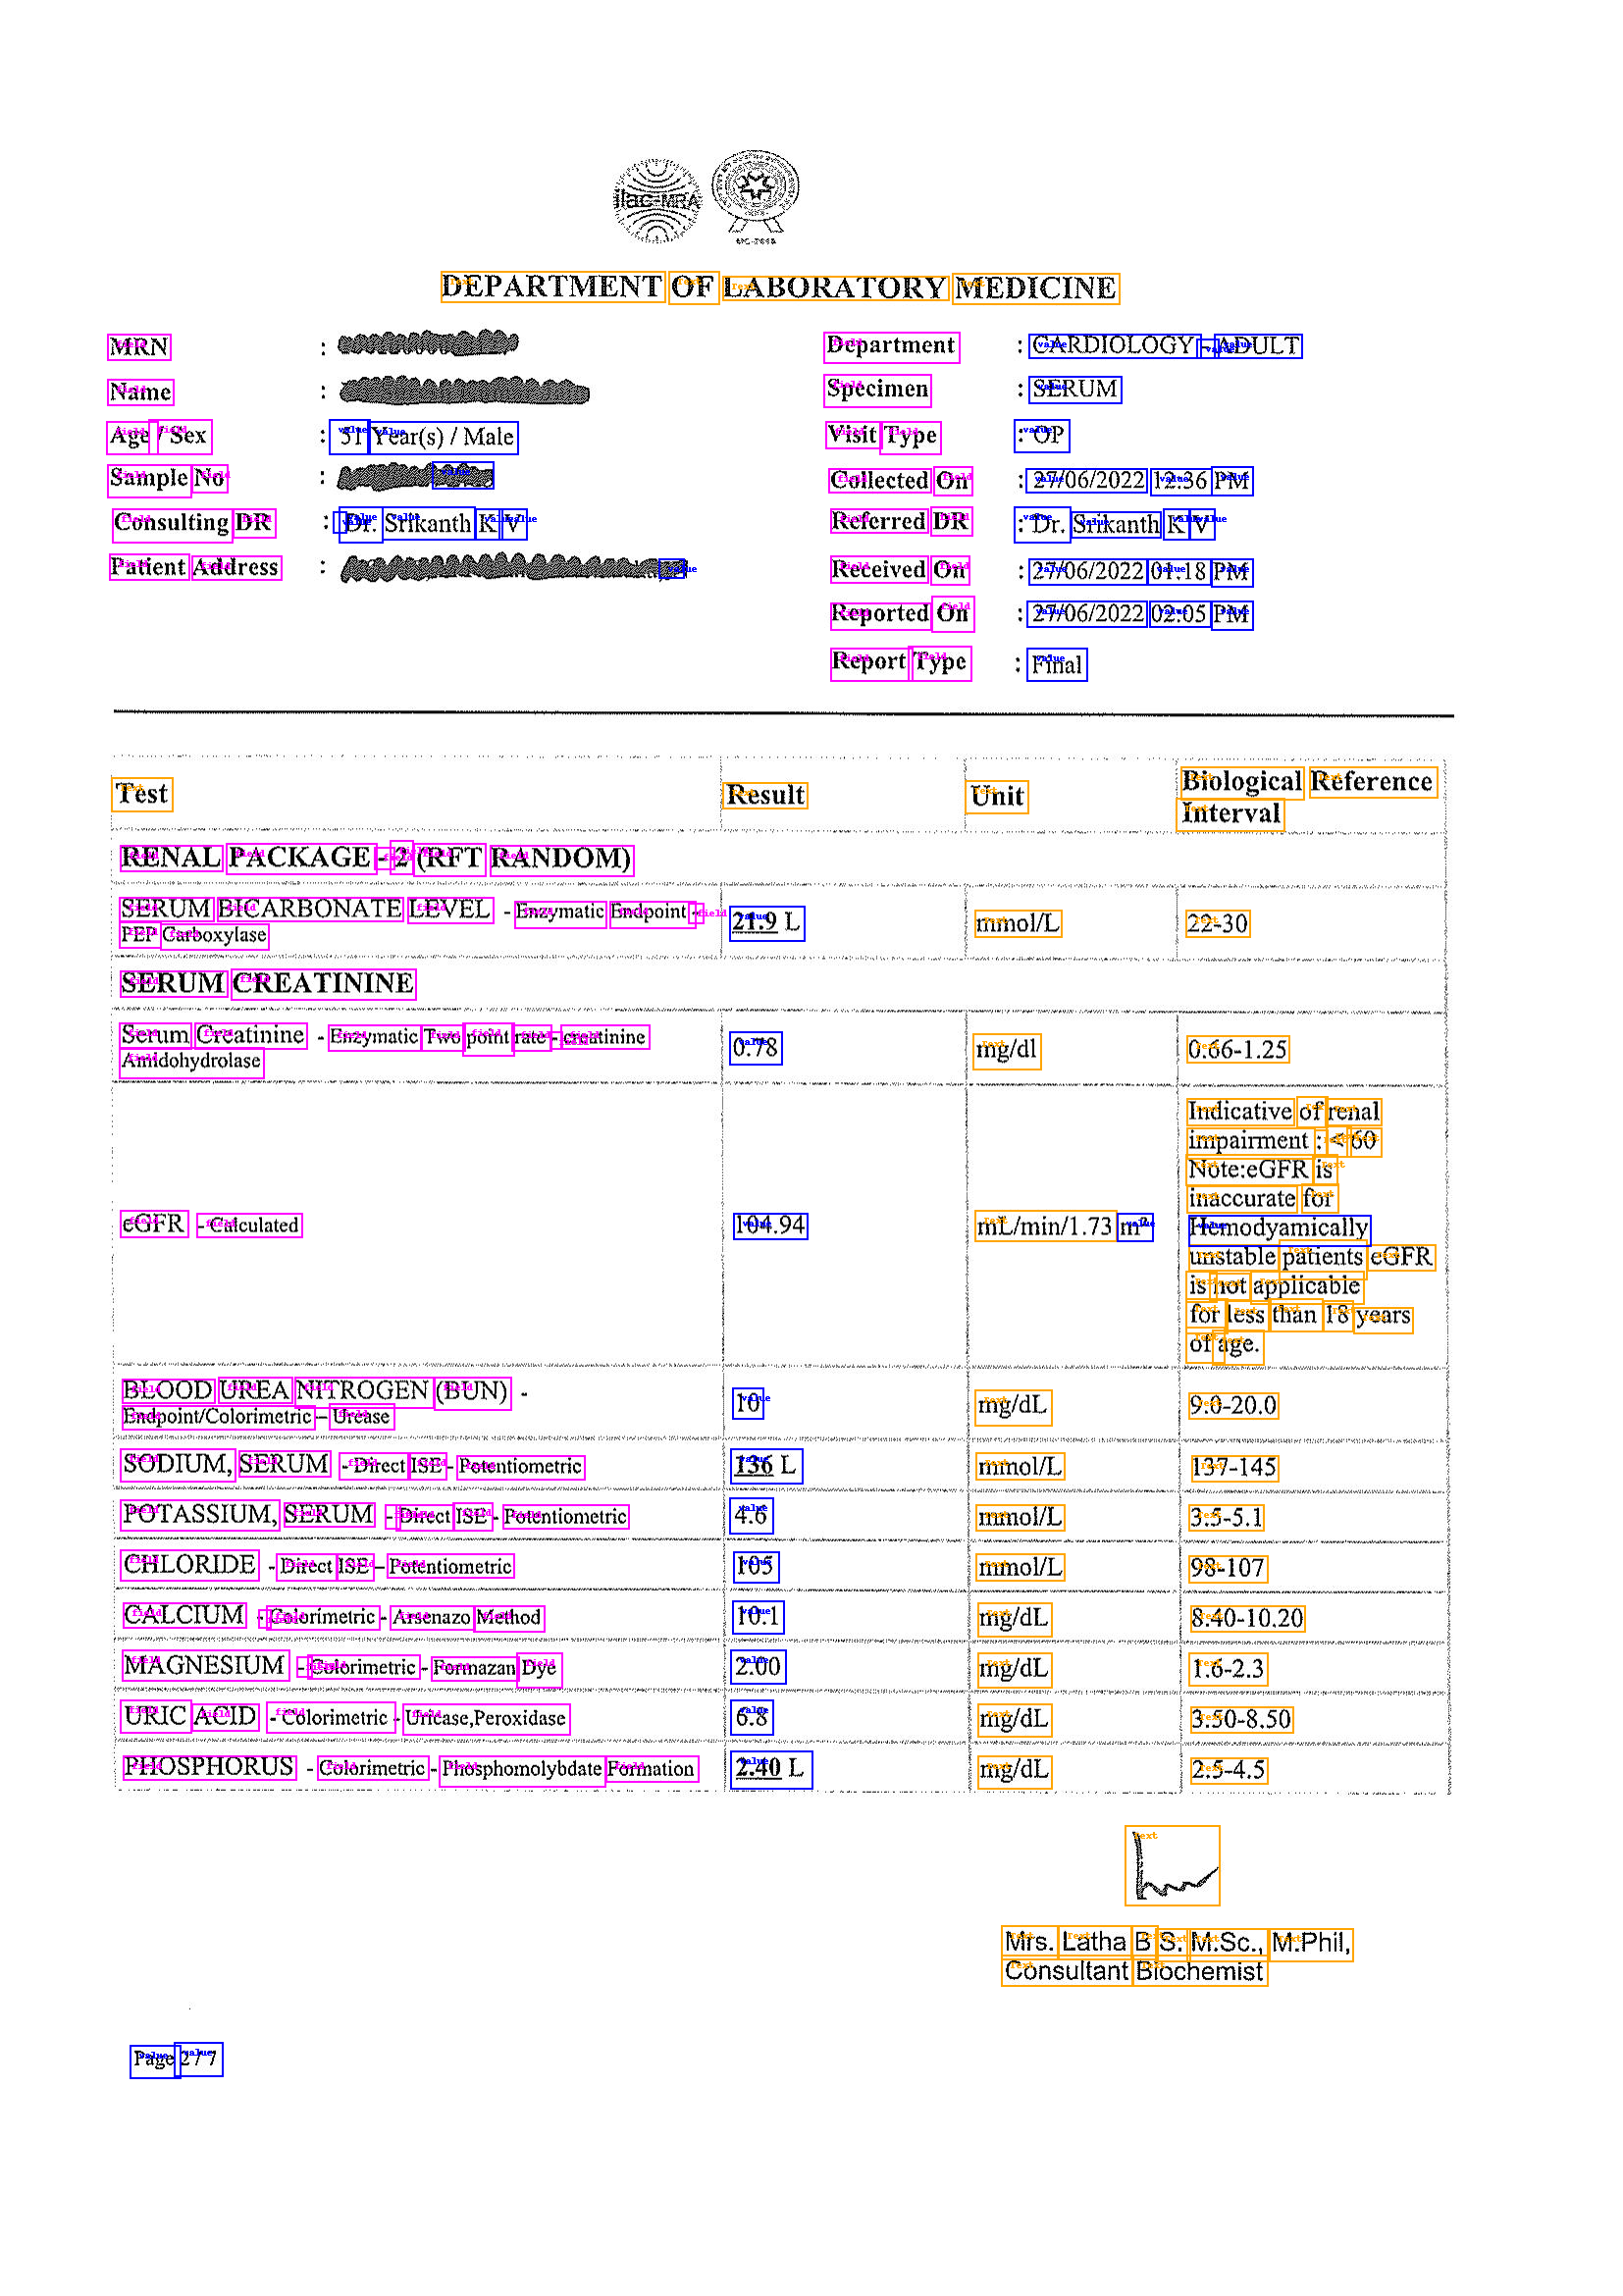

In [14]:
import pandas as pd
import os
import pickle
import matplotlib.image as mpimg    

# directory = 'pdf_images/NH BC 00181/'
# dir = './img/'
# i=0
# for i,filename in enumerate(os.listdir(directory)):
image = Image.open(f"pdf_images/NH BC 00150/NH BC 00150page2.jpg")
image = image.convert("RGB")
draw = ImageDraw.Draw(image)
font = ImageFont.load_default()
# f = os.path.join(directory, filename)
# image=np.array(image)
# print(image)
word=demo[0][1]
label=preds_list[1]
bbox=demo[2][1]
all_data_ = list(zip(word,label,bbox))
ocr_data_ = pd.DataFrame(all_data_, columns=['word', 'label','bbox'])
data=list(ocr_data_.itertuples(index=False, name=None))
label2color = {'field':'magenta', 'value':'blue', 'Text':'orange'}
for word,label,bbox in data:
    draw.rectangle(bbox, outline=label2color[label],width=2)
    draw.text((bbox[0] + 10, bbox[1]+5), label, fill=label2color[label], font=font)      
# os.chdir(dir)
# file = dir
# cv2.imwrite(f"{file}/{filename}",image)
image                                                                                                                                       